# Kaggle Red Hat Predicting Business Value.

### Premise : The goal of the Kaggle Red Hat competition is to predict the business value of each customer. The business value is related to the whether the activities are performed successfully or not.

### There are 3 datasets : Train, Test and People. Each row in the people dataset has a unique customer (people_id) who has performed a certain activity. Each row in Test and Train contains a unique activity performed by customers.


### All of these activities are performed in a certain TIME FRAME (date). Our job was to correctly classify each activity in the test set as to whether they are performed successfully (1) or not (0). 

## 1. Importing and Reading the data.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


In [2]:
#reading the datasets as pandas dataframes
train = pd.read_csv("C:/Users/kausha2/Documents/Datasets/Kaggle_Red Hat/DataSets/act_train.csv", parse_dates=['date'])
test = pd.read_csv("C:/Users/kausha2/Documents/Datasets/Kaggle_Red Hat/DataSets/act_test.csv", parse_dates=['date'])
people = pd.read_csv("C:/Users/kausha2/Documents/Datasets/Kaggle_Red Hat/DataSets/people.csv", parse_dates=['date'])

## 2. Data Wrangling Part 1 : Simplifying the date, and dropping char_10 which drops the accuracy by 20% and gives inconsistent results

In [3]:
# fixing the column types
train['people_id'].astype(np.str,inplace = True)
train['activity_id'].astype(np.str)
train['outcome'].astype(np.int8)
train.head()

# dropping char_10 as it creates tremendous problems while using classifiers.
train.drop('char_10', axis =1, inplace=True )

#cleaning up test
test['people_id'].astype(np.str,inplace = True)
test['activity_id'].astype(np.str)
test.head()

# dropping char_10 as it creates tremendous problems while using classifiers.
test.drop('char_10', axis =1, inplace=True )

#same for people_id
people['people_id'].astype(np.str,inplace = True)

# dropping char_10 as it creates tremendous problems while using classifiers.
people.drop('char_10', axis =1, inplace=True )
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,...,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,False,False,True,False,False,False,True,True,False,84


In [4]:
#adding year,month and day columns. Trying a new 'weekend' column
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['isweekend'] = (train['date'].dt.weekday >= 5).astype(int)
train = train.drop('date', axis = 1)


test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['isweekend'] = (test['date'].dt.weekday >= 5).astype(int)
test = test.drop('date', axis = 1)


people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people['isweekend'] = (people['date'].dt.weekday >= 5).astype(int)
people = people.drop('date', axis = 1)

In [5]:
#For Train
for i in list(train.columns): #To exclude the following columns as they're already in the format we want!
    if i not in ['people_id', 'activity_id', 'date', 'outcome']:
        if train[i].dtype == 'object': #for object type, all NA'sare filled with a 'type zero'
            train[i].fillna('type 0', inplace=True)
            train[i] = train[i].apply(lambda x: x.split(' ')[1]).astype(np.int32) #get rid of 'type'!
        elif train[i].dtype == 'bool':
            train[i] = train[i].astype(np.int8)

#For Test
for i in list(test.columns): #To exclude the following columns as they're already in the format we want!
    if i not in ['people_id', 'activity_id', 'date', 'outcome']:
        if test[i].dtype == 'object': #for object type, all NA's are filled with a 'type zero'
            test[i].fillna('type 0', inplace=True)
            test[i] = test[i].apply(lambda x: x.split(' ')[1]).astype(np.int32) #get rid of 'type'!
        elif test[i].dtype == 'bool':
                test[i] = test[i].astype(np.int8)
#For People
for i in list(people.columns): #To exclude the following columns as they're already in the format we want!
    if i not in ['people_id', 'activity_id', 'date', 'char_38', 'outcome']:
        if people[i].dtype == 'object': #for object type, all NA'sare filled with a 'type zero'
            people[i].fillna('type 0', inplace=True)
            people[i] = people[i].apply(lambda x: x.split(' ')[1]).astype(np.int32) #get rid of 'type'!
        elif people[i].dtype == 'bool':
                people[i] = people[i].astype(np.int8)

In [6]:
train.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,outcome,year,month,day,isweekend
0,ppl_100,act2_1734928,4,0,0,0,0,0,0,0,0,0,0,2023,8,26,1
1,ppl_100,act2_2434093,2,0,0,0,0,0,0,0,0,0,0,2022,9,27,0
2,ppl_100,act2_3404049,2,0,0,0,0,0,0,0,0,0,0,2022,9,27,0
3,ppl_100,act2_3651215,2,0,0,0,0,0,0,0,0,0,0,2023,8,4,0
4,ppl_100,act2_4109017,2,0,0,0,0,0,0,0,0,0,0,2023,8,26,1


In [7]:
test.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,year,month,day,isweekend
0,ppl_100004,act1_249281,1,5,10,5,1,6,1,1,7,4,2022,7,20,0
1,ppl_100004,act2_230855,5,0,0,0,0,0,0,0,0,0,2022,7,20,0
2,ppl_10001,act1_240724,1,12,1,5,4,6,1,1,13,10,2022,10,14,0
3,ppl_10001,act1_83552,1,20,10,5,4,6,1,1,5,5,2022,11,27,1
4,ppl_10001,act2_1043301,5,0,0,0,0,0,0,0,0,0,2022,10,15,1


In [8]:
people.head()

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,...,char_33,char_34,char_35,char_36,char_37,char_38,year,month,day,isweekend
0,ppl_100,2,17304,2,5,5,5,3,11,2,...,0,1,1,1,0,36,2021,6,29,0
1,ppl_100002,2,8688,3,28,9,5,3,11,2,...,1,1,1,1,0,76,2021,1,6,0
2,ppl_100003,2,33592,3,4,8,5,2,5,2,...,1,1,0,1,1,99,2022,6,10,0
3,ppl_100004,2,22593,3,40,25,9,4,16,2,...,1,1,1,1,1,76,2022,7,20,0
4,ppl_100006,2,6534,3,40,25,9,3,8,2,...,0,0,1,1,0,84,2022,7,27,0


## 3. Merging the test and train datasets with the people dataset

In [9]:
#Merge Train and People first. We use a LEFT JOIN.
train = train.merge(people, on='people_id', how='left', left_index=True)
test = test.merge(people, on='people_id', how='left', left_index=True)

## 4. Data Wrangling Part 2 : Converting the people_id and activity_id into values that the Machine Learning program can read.

In [10]:
train.head()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y
0,ppl_100,act2_1734928,4,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0
0,ppl_100,act2_2434093,2,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0
0,ppl_100,act2_3404049,2,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0
0,ppl_100,act2_3651215,2,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0
0,ppl_100,act2_4109017,2,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0


In [11]:
test.head()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y
3,ppl_100004,act1_249281,1,5,10,5,1,6,1,1,...,1,1,1,1,1,76,2022,7,20,0
3,ppl_100004,act2_230855,5,0,0,0,0,0,0,0,...,1,1,1,1,1,76,2022,7,20,0
5,ppl_10001,act1_240724,1,12,1,5,4,6,1,1,...,1,1,1,1,1,90,2022,10,14,0
5,ppl_10001,act1_83552,1,20,10,5,4,6,1,1,...,1,1,1,1,1,90,2022,10,14,0
5,ppl_10001,act2_1043301,5,0,0,0,0,0,0,0,...,1,1,1,1,1,90,2022,10,14,0


In [12]:
train['people'] = train['people_id'].apply(lambda x: x.split('_')[1]).astype(np.str)
train['people'].astype(np.float64,inplace = True)

train['act'] = train['activity_id'].apply(lambda x: x.split('act')[1]).astype(np.str) #get rid of 'act'!
train['act'] = train['act'].apply(lambda x: x.split('_')[0]).astype(np.str) #get rid of 'act'!
train['act'].astype(np.float64, inplace = True)
train.head()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y,people,act
0,ppl_100,act2_1734928,4,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_2434093,2,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_3404049,2,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_3651215,2,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_4109017,2,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2


In [13]:
train.act.describe()

count     2197291
unique          2
top             2
freq      2039676
Name: act, dtype: object

In [14]:
train.columns.difference(test.columns)

#How many columns in Train are different from Test.

Index(['act', 'outcome', 'people'], dtype='object')

### 4.1 Checking for duplicate columns

In [15]:
#train['Check1xy'] = 0

In [16]:
#for i in list(people.columns): #To exclude the following columns as they're already in the format we want!
 #   if  [train['char_1_x'] == train['char_1_y']]:
    #   train['Check1xy'] = 1
        

In [17]:
#train.drop('Check1xy', axis = 1,inplace = True)
train.head()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y,people,act
0,ppl_100,act2_1734928,4,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_2434093,2,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_3404049,2,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_3651215,2,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_4109017,2,0,0,0,0,0,0,0,...,1,1,0,36,2021,6,29,0,100,2


In [18]:
len(train.columns)

61

### 4.2 Dropping Multiple columns that mess up the accuracy score!

In [19]:
train.drop(['char_1_x','char_2_x','char_3_x','char_4_x','char_5_x','char_6_x','char_7_x','char_8_x','char_9_x','year_x','month_x','day_x','isweekend_x'], axis = 1, inplace = True)
train.columns

Index(['people_id', 'activity_id', 'activity_category', 'outcome', 'char_1_y',
       'group_1', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y',
       'char_7_y', 'char_8_y', 'char_9_y', 'char_11', 'char_12', 'char_13',
       'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19',
       'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25',
       'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31',
       'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37',
       'char_38', 'year_y', 'month_y', 'day_y', 'isweekend_y', 'people',
       'act'],
      dtype='object')

In [20]:
train.head()

,people_id,activity_id,activity_category,outcome,char_1_y,group_1,char_2_y,char_3_y,char_4_y,char_5_y,...,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y,people,act
0,ppl_100,act2_1734928,4,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_2434093,2,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_3404049,2,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_3651215,2,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_4109017,2,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2


### 4.3 What are the column names?

In [21]:
train.columns

Index(['people_id', 'activity_id', 'activity_category', 'outcome', 'char_1_y',
       'group_1', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y',
       'char_7_y', 'char_8_y', 'char_9_y', 'char_11', 'char_12', 'char_13',
       'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19',
       'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25',
       'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31',
       'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37',
       'char_38', 'year_y', 'month_y', 'day_y', 'isweekend_y', 'people',
       'act'],
      dtype='object')

In [22]:
#train['char_qual'] = train['char_11'] + train['char_12'] + train['char_13'] + train['char_14'] + train['char_15'] + train['char_16'] + train['char_17'] + train['char_18'] + train['char_19'] +train['char_20'] + train['char_21'] + train['char_22'] + train['char_23'] + train['char_24'] + train['char_25'] +train['char_26'] + train['char_27'] + train['char_28'] + train['char_29'] + train['char_30'] + train['char_31'] + train['char_32']+  train['char_33'] + train['char_34'] + train['char_35'] + train['char_36'] + train['char_37'] 

#### The above and bottom code snippets are the failed features.

In [23]:
#train['char_type_add'] = train['char_1_y'] + train['char_2_y'] + train['char_3_y'] + train['char_4_y'] + train['char_5_y'] + train['char_6_y'] + train['char_7_y'] + train['char_8_y'] + train['char_9_y']

In [24]:
train.head()

,people_id,activity_id,activity_category,outcome,char_1_y,group_1,char_2_y,char_3_y,char_4_y,char_5_y,...,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y,people,act
0,ppl_100,act2_1734928,4,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_2434093,2,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_3404049,2,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_3651215,2,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2
0,ppl_100,act2_4109017,2,0,2,17304,2,5,5,5,...,1,1,0,36,2021,6,29,0,100,2


In [25]:
#train_new = train[['char_38', 'year_y', 'month_y', 'day_y', 'isweekend_y', 
                   #'people', 'act', 'group_1','activity_category','char_type_add']]

In [26]:
#train_new.head()

## 5. creating the Features and Labels for the ML classifiers

In [27]:
#making the features and labels for the data
labels = train.outcome
train1 = train.drop('outcome', axis = 1)
features = np.array (train1.iloc[:,2:])



### 5.1 Tried getting rid of group_id = 17304 but it gave reduced accuracy so made an ensemble model in the end

In [28]:
#train_new[train['group_1']!= 17304]
#features = train_new

In [29]:
#Checking for missing values
print("Number of missing values in Labels :" , np.sum(np.isnan(labels)))


Number of missing values in Labels : 0


In [30]:
#CrossValidation Check!

from sklearn.cross_validation import train_test_split

#labels is the dependent variable.
#features are the set of independent variables.
# Split the data into a training set and a test set

X_train, X_test, y_train, y_test = train_test_split(features, labels,
test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1538103, 45) (659188, 45) (1538103,) (659188,)


## 6. Machine Learning or Data mining : Running different classifiers!!

In [32]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
preddt = clf.predict(X_test)
Score1 = accuracy_score(preddt, y_test)
print("The Accuracy Score using Decision Trees is ",Score1*100, "%")

The Accuracy Score using Decision Trees is  97.3817787945 %


In [33]:
clf = RandomForestClassifier()

clf = clf.fit(X_train, y_train)
predrf = clf.predict(X_test)
Score2 = accuracy_score(predrf, y_test)
print("The Accuracy Score using RF is ",Score2*100, "%")

The Accuracy Score using RF is  97.4369982463 %


In [34]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf = clf.fit(X_train, y_train)

predgb = clf.predict(X_test)
Score3 = accuracy_score(predgb, y_test)
print("The Accuracy Score using Gradient Boosting is ",Score3*100, "%")

The Accuracy Score using Gradient Boosting is  86.5886514924 %


In [35]:
Score_Matrix = pd.DataFrame({'Decision Tree' : [Score1*100],
                         'Random Forest' : [Score2*100],
                         'Gradient Booster': [Score3*100]})

In [36]:
Score_Matrix

,Decision Tree,Gradient Booster,Random Forest
0,97.381779,86.588651,97.436998


### The RandomForest and Decision Tree classifiers are very effective here. Running other powerful classifiers such as KNN and SVM takes too long to process!

## 7. Munging and preparing the Test Dataset for Prediction

In [34]:
test['people'] = test['people_id'].apply(lambda x: x.split('_')[1]).astype(np.str)
test['people'].astype(np.float64,inplace = True)

test['act'] = test['activity_id'].apply(lambda x: x.split('act')[1]).astype(np.str) #get rid of 'act'!
test['act'] = test['act'].apply(lambda x: x.split('_')[0]).astype(np.str) #get rid of 'act'!
test['act'].astype(np.float64, inplace = True)
test.head()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y,people,act
3,ppl_100004,act1_249281,1,5,10,5,1,6,1,1,...,1,1,1,76,2022,7,20,0,100004,1
3,ppl_100004,act2_230855,5,0,0,0,0,0,0,0,...,1,1,1,76,2022,7,20,0,100004,2
5,ppl_10001,act1_240724,1,12,1,5,4,6,1,1,...,1,1,1,90,2022,10,14,0,10001,1
5,ppl_10001,act1_83552,1,20,10,5,4,6,1,1,...,1,1,1,90,2022,10,14,0,10001,1
5,ppl_10001,act2_1043301,5,0,0,0,0,0,0,0,...,1,1,1,90,2022,10,14,0,10001,2


## 8. Dropping the excess trash variables from the Test set

In [35]:
test.drop(['char_1_x','char_2_x','char_3_x','char_4_x','char_5_x','char_6_x',
           'char_7_x','char_8_x','char_9_x','year_x','month_x','day_x','isweekend_x'], axis = 1, inplace = True)


test.columns

Index(['people_id', 'activity_id', 'activity_category', 'char_1_y', 'group_1',
       'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y',
       'char_8_y', 'char_9_y', 'char_11', 'char_12', 'char_13', 'char_14',
       'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20',
       'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26',
       'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32',
       'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38',
       'year_y', 'month_y', 'day_y', 'isweekend_y', 'people', 'act'],
      dtype='object')

In [36]:
test.columns.difference(train.columns)


Index([], dtype='object')

In [37]:
#Aggregating columns : 
#test['char_type_add'] = test['char_1_y'] + test['char_2_y'] + test['char_3_y'] + test['char_4_y'] + test['char_5_y'] + test['char_6_y'] + test['char_7_y'] + test['char_8_y'] + test['char_9_y']

#test['char_qual'] = test['char_11'] + test['char_12'] + test['char_13'] + test['char_14'] + test['char_15'] + test['char_16'] + test['char_17'] + test['char_18'] + test['char_19'] + test['char_20'] + test['char_21'] + test['char_22'] + test['char_23'] + test['char_24'] + test['char_25'] + test['char_26'] + test['char_27'] + test['char_28'] + test['char_29'] + test['char_30'] + test['char_31'] + test['char_32']+  test['char_33'] + test['char_34'] + test['char_35'] + test['char_36'] + test['char_37'] 

newfeatures = np.array (test.iloc[:,2:])

#### Failed features are commented out

In [38]:
#test_new = test[['char_38', 'year_y', 'month_y', 'day_y', 'isweekend_y', 
                   #'people', 'act', 'group_1','activity_category','char_type_add']]

#feats = test_new

In [39]:
#test_dont[test_new['group_1'] == 17304]
#test_run[test_new['group_1'] != 17304]

In [ ]:
#feats = test_new[test_new['group_1']!=17304]

## 9. Running the classifiers on the entire dataset 

In [ ]:
from sklearn import tree
clf1 = tree.DecisionTreeClassifier()
clf1 = clf1.fit(features, labels)
pred1 = clf1.predict(newfeatures)


from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier()
clf2 = clf2.fit(features, labels)
pred2 = clf2.predict(newfeatures)


from sklearn.ensemble import GradientBoostingClassifier
clf3 = GradientBoostingClassifier()
clf3 = clf3.fit(features, labels)
pred3 = clf3.predict(newfeatures)


test['pred_baseline'] = 0
test['pred_dt'] = pd.Series(pred1)
test['pred_rf'] = pd.Series(pred2)
test['pred_gb'] = pd.Series(pred3)

test.loc[test['group_1'] == 17304, 'pred_dt'] = 0
test.loc[test['group_1'] == 17304, 'pred_rf'] = 0
test.loc[test['group_1'] == 17304, 'pred_gb'] = 0

In [ ]:
test['pred_baseline'] = 0
test['pred_dt'] = pd.Series(pred1)
test['pred_rf'] = pd.Series(pred2)
test['pred_gb'] = pd.Series(pred3)

In [ ]:
test.loc[test['group_1'] == 17304, 'pred_dt'] = 0
test.loc[test['group_1'] == 17304, 'pred_rf'] = 0
test.loc[test['group_1'] == 17304, 'pred_gb'] = 0

## 10. Creating the submission dataset

In [ ]:
test.head()

In [103]:
df = pd.DataFrame({ 'activity_id' : test['activity_id'], 'outcome': test['pred_dt'] })
df2 = pd.DataFrame({ 'activity_id' : test['activity_id'], 'outcome': test['pred_rf'] })
df3 = pd.DataFrame({ 'activity_id' : test['activity_id'], 'outcome': test['pred_gb'] })
df0 = pd.DataFrame({ 'activity_id' : test['activity_id'], 'outcome': test['pred_baseline'] })

df.to_csv('C:/Users/kausha2/Documents/Datasets/Kaggle_Red Hat/DataSets/dtree_final.csv', index = False)
df2.to_csv('C:/Users/kausha2/Documents/Datasets/Kaggle_Red Hat/DataSets/rforest.csv', index = False)
df3.to_csv('C:/Users/kausha2/Documents/Datasets/Kaggle_Red Hat/DataSets/gbooster.csv', index = False)

df0.to_csv('C:/Users/kausha2/Documents/Datasets/Kaggle_Red Hat/DataSets/baseline.csv', index = False)

#Agredate by goup id
#filter for all groups in which sum is zero
#ewach row : 0 in test for 17304
#Score = accuracy_score(pred1, pred2)
#print("The Accuracy Score using DT to RF is ",Score*100, "%")

#Score = accuracy_score(pred2, pred3)
#print("The Accuracy Score using RF to GB is ",Score*100, "%")


#Score = accuracy_score(pred1, pred3)
#print("The Accuracy Score using DT to GB is ",Score*100, "%")

df0 = pd.DataFrame({ 'activity_id' : test['activity_id'], 'outcome': test['pred_baseline'] })
df0.to_csv('C:/Users/kausha2/Documents/Datasets/Kaggle_Red Hat/DataSets/baseline.csv', index = False)


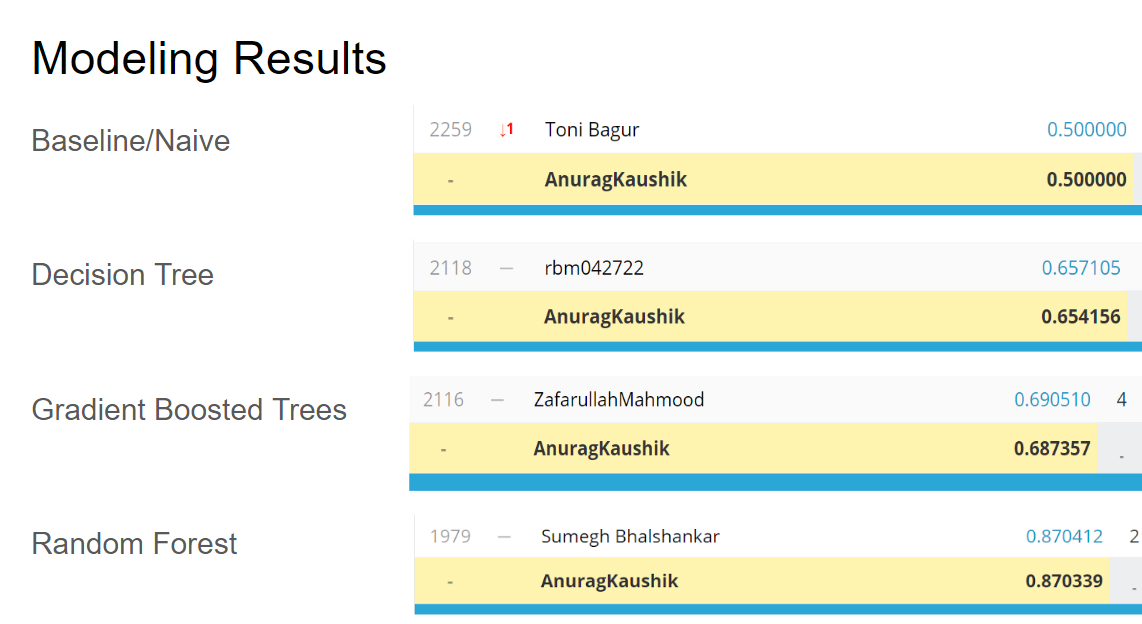

In [2]:
from IPython.display import Image
Image(filename='C:/Users/kausha2/Documents/Tech_Fundamentals/ML_Results.PNG')

##  11. Wrapping up :
### 0.87 or 87% on the leaderboard of Kaggle. Evaluation method :Area under the ROC curve
### Baseline model was 50%

### The Kaggle results are present in the main document
